# Revisit Severson et al.
Peter Attia

This notebook contains most of the figures and code for our paper re-analyzing the dataset in
[Severson et al.](https://energy.stanford.edu/sites/g/files/sbiybj9971/f/346501527888d799d94279cfe74049fde53ca2d5a1275d083d28f925253cf657.pdf)

In [1]:
import os
import glob
from pathlib import Path
from functools import reduce

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd

from scipy.stats import skew, kurtosis
from sklearn import preprocessing
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNetCV
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from image_annotated_heatmap import heatmap, annotate_heatmap

## Settings

Set plotting settings:

In [2]:
fig_width = 3.25 # ECS spec is 3.25" width
fig_width_2col = 7
fig_height = (3 / 4) * fig_width # standard ratio

rcParams['figure.autolayout'] = True
rcParams['lines.markersize'] = 5
rcParams['lines.linewidth'] = 1.0
rcParams['font.size'] = 7
rcParams['legend.fontsize'] = 7
rcParams['legend.frameon'] = False
rcParams['xtick.minor.visible'] = True
rcParams['ytick.minor.visible'] = True
rcParams['font.sans-serif'] = 'Arial'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

Set path for saving figures:

In [3]:
figpath = Path.cwd() / 'figs'

Define linearly spaced voltage vector (consistent with Severson):

In [4]:
Vdlin = np.linspace(3.6, 2, 1000)

Define `alphas` and `l1_ratios` to use for `RidgeCV` and `ElasticNetCV` hyperparameter optimization:

In [5]:
l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
alphas = np.logspace(0.001, 100, 20)

## Load data
The data is stored in the `data` directory. The data was generated by the `generate_voltage_array.m` MATLAB script, which creates three folders of "voltage arrays" for the train, test1, and test2 splits in Severson et al.

We will load each dataset as 3D arrays of `[cell idx, voltage position, cycle number]`.

Note that because cycle 1 is unavailable for one batch, position 0 in axis 2 is cycle 2.
Similarly, cycle 100 is position 98 in axis 2.
In describing the cycle numbers in the text, I assume the first cycle is cycle 1 (i.e. references to cycle number in the text are one-indexed, not zero-indexed).

In [6]:
def sortKeyFunc(s):
    return int(os.path.basename(s)[4:-4])

def load_dataset(folder):
    files = glob.glob(f'./data/{folder}/*.csv')
    files.sort(key=sortKeyFunc) # glob returns list with arbitrary order
    
    l = len(files)
    dataset = np.zeros((l, 1000, 99))
    
    for k, file in enumerate(files):
        cell = np.genfromtxt(file, delimiter=',')
        dataset[k,:,:] = cell # flip voltage dimension
    
    return dataset

Load three datasets (`test1` = primary test set, `test2` = secondary test set):

In [7]:
data_train = load_dataset('train')
data_test1 = load_dataset('test1')
data_test2 = load_dataset('test2')

Load cycle lives:

In [8]:
cycle_lives_train = np.genfromtxt('./data/cycle_lives/train_cycle_lives.csv', delimiter=',')
cycle_lives_test1 = np.genfromtxt('./data/cycle_lives/test1_cycle_lives.csv', delimiter=',')
cycle_lives_test2 = np.genfromtxt('./data/cycle_lives/test2_cycle_lives.csv', delimiter=',')

Confirm 124 cells are loaded:

In [9]:
print(len(data_train) + len(data_test1) + len(data_test2))
print(len(cycle_lives_train) + len(cycle_lives_test1) + len(cycle_lives_test2))

124
124


Define `y` values as log10 of cycle life:

In [10]:
y_train = np.log10(cycle_lives_train)
y_test1 = np.log10(cycle_lives_test1)
y_test2 = np.log10(cycle_lives_test2)

Make a new version of `data_test1`, `cycle_lives_test1` and `y_test1` that exclude the outlier battery:

In [11]:
data_test1_mod = data_test1.copy()
cycle_lives_test1_mod = cycle_lives_test1.copy()
y_test1_mod = y_test1.copy()

data_test1_mod = np.delete(data_test1_mod, 21, axis=0)
cycle_lives_test1_mod = np.delete(cycle_lives_test1_mod, 21)
y_test1_mod = np.delete(y_test1_mod, 21)

## Voltage array illustration

This figure illustrates the voltage array (V vs. Q & cycle number) concept.

In [12]:
# Find sample cell in training set
cellNum = 19
sample = data_train[cellNum,:,:]

# Define Qsub and Qdiv (normalized to cycle 2)
Qsub = (sample[:,:].T - sample[:,0]).T
Qdiv = (sample[:,:].T / sample[:,0]).T

# Set voltage indices for linecuts
idx1 = 220
idx2 = 400

Make figure:

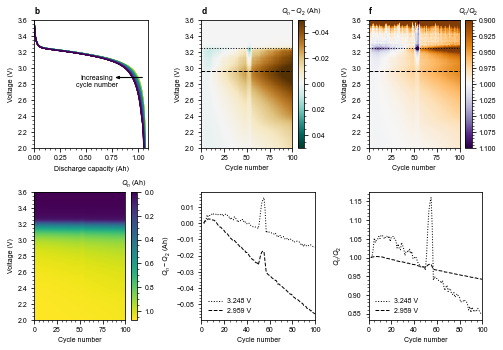

In [13]:
fig, ax = plt.subplots(figsize=(fig_width_2col, 2 * fig_height),
                       nrows=2, ncols=3)
ax = ax.ravel()

colors = cm.get_cmap('viridis_r')(np.linspace(0, 1, 99))

for k in np.arange(3):
    ax[k].set_title(chr(97 + 2*k), loc='left', weight='bold') # a, c, e
    ax[k].set_title(chr(98 + 2*k), loc='left', weight='bold') # b, d, f
    
# Set xlabels
ax[0].set_xlabel('Discharge capacity (Ah)')
ax[0].set_xlim((0,1.1))
for k in np.arange(1, 6):
    ax[k].set_xlabel('Cycle number')
    ax[k].set_xlim([0, 100])
    
# Set ylabels
for k in np.arange(4):
    ax[k].set_ylabel('Voltage (V)')
    ax[k].set_ylim([2, 3.6])
ax[4].set_ylabel(r'$Q_n-Q_2$' + ' (Ah)')
ax[5].set_ylabel(r'$Q_n/Q_2$')

# Panel A: Voltage curves
for k in np.arange(99):
    ax[0].plot(sample[:,k], Vdlin, color=colors[k])
ax[0].arrow(0.95, 0.55, -0.2, 0, transform=ax[0].transAxes,
            zorder=3, head_width=0.02, color='k')
ax[0].text(0.55, 0.52, 'Increasing\ncycle number', horizontalalignment='center',
           verticalalignment='center', transform=ax[0].transAxes)

# Panel B: Voltage matrix
im = ax[3].imshow(sample, extent=[0, 100, 3.6, 2.0],
                  aspect='auto', origin='lower')
cbar = fig.colorbar(im, ax=ax[3])
cbar.ax.set_title(r'$Q_n$'+' (Ah)', fontsize=7)
cbar.ax.invert_yaxis()

# Panel C: Qn - Q2
im1 = ax[1].imshow(Qsub, extent=[0, 100, 3.6, 2.0],
                   aspect='auto', origin='lower',
                   cmap='BrBG', vmin=-0.05, vmax=0.05)

# Panel E: Qn / Q2
im2 = ax[2].imshow(Qdiv, extent=[0, 100, 3.6, 2.0],
                   aspect='auto', origin='lower',
                   cmap='PuOr', vmin=0.9, vmax=1.1)
images = [im1, im2]

# Common to C and E
for k in [1, 2]:
    cbar_title = r'$Q_n-Q_2$'+' (Ah)' if k == 1 else r'$Q_n/Q_2$'
    
    ax[k].axhline(Vdlin[idx1], color='k', ls=':')
    ax[k].axhline(Vdlin[idx2], color='k', ls='--')
    cbar = fig.colorbar(images[k-1], ax=ax[k])
    cbar.ax.invert_yaxis()
    cbar.ax.set_title(cbar_title, fontsize=7)

# Panel D and F: Qn - Q2, Qn / Q2
for k in [4, 5]:
    Qsub_or_Qdiv = Qsub if k == 4 else Qdiv
    
    ax[k].plot(np.arange(2, 101), Qsub_or_Qdiv[idx1,:], 'k', ls=':',  label=f'{Vdlin[idx1]:0.3f} V')
    ax[k].plot(np.arange(2, 101), Qsub_or_Qdiv[idx2,:], 'k', ls='--', label=f'{Vdlin[idx2]:0.3f} V')
    ax[k].legend(loc='lower left')

# Save
plt.tight_layout()
plt.savefig(figpath / 'fig1_voltage_matrix.eps', format='eps')

$Q_n - Q_2$ and $Q_n / Q_2$ contain similar information, but $Q_n / Q_2$ appears more sensitive to temperature fluctuations at its most sensitive point.
For now we proceed with $Q_n - Q_2$ as per Severson.

## Sampling frequency

How frequently do we need to sample the voltage matrix in the voltage dimension?

Define sampling frequencies for illustration plot. Here we use all factors of 1000:

In [14]:
# Short function, from this SO post:
# https://stackoverflow.com/questions/6800193/what-is-the-most-efficient-way-of-finding-all-the-factors-of-a-number-in-python
def factors(n):
    return sorted(list(reduce(list.__add__,
                              ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0))))

All factors of 1000: 

In [15]:
sampling_frequencies = factors(1000)[:-1] # exclude 1000
sampling_frequencies

[1, 2, 4, 5, 8, 10, 20, 25, 40, 50, 100, 125, 200, 250, 500]

Convert to mV equivalents via `voltage window / (1000 points / n_samples) * (1000 mV/1 V)`:

In [16]:
mV_frequencies = (3.6 - 2.0) / (1000 / np.array(sampling_frequencies)) * 1000 # mV
mV_frequencies

array([  1.6,   3.2,   6.4,   8. ,  12.8,  16. ,  32. ,  40. ,  64. ,
        80. , 160. , 200. , 320. , 400. , 800. ])

Train model on $ \log_{10}($var$(\Delta Q_{100-10}(V) ))$:

In [17]:
RMSE_train = np.zeros((len(sampling_frequencies, )))
RMSE_test1 = np.zeros((len(sampling_frequencies, )))
RMSE_test2 = np.zeros((len(sampling_frequencies, )))

for k, freq in enumerate(sampling_frequencies):
    
    # Define the log10 of the variance of Q100 - Q10, with different sampling frequencies:
    X_train = np.log10(np.var((data_train[:, ::freq, 98] - data_train[:, ::freq, 8]), axis=1))
    X_test1 = np.log10(np.var((data_test1_mod[:, ::freq, 98] - data_test1_mod[:, ::freq, 8]), axis=1))
    X_test2 = np.log10(np.var((data_test2[:, ::freq, 98] - data_test2[:, ::freq, 8]), axis=1))

    # Scale via standarization:
    scaler = preprocessing.StandardScaler().fit(X_train.reshape(-1, 1))
    X_train_scaled = scaler.transform(X_train.reshape(-1, 1))
    X_test1_scaled = scaler.transform(X_test1.reshape(-1, 1))
    X_test2_scaled = scaler.transform(X_test2.reshape(-1, 1))

    # Define and fit linear regression via enet
    enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0)
    enet.fit(X_train_scaled.reshape(-1, 1), y_train)

    # Predict on test sets
    y_train_pred = enet.predict(X_train_scaled)
    y_test1_pred = enet.predict(X_test1_scaled)
    y_test2_pred = enet.predict(X_test2_scaled)
        
    RMSE_train[k] = mean_squared_error(np.power(10, y_train), np.power(10, y_train_pred), squared=False)
    RMSE_test1[k] = mean_squared_error(np.power(10, y_test1_mod), np.power(10, y_test1_pred), squared=False)
    RMSE_test2[k] = mean_squared_error(np.power(10, y_test2), np.power(10, y_test2_pred), squared=False)

Confirm models match up with Table 1 from Severson: RMSE = (103, 138, 196)

In [18]:
RMSE_train[0], RMSE_test1[0], RMSE_test2[0]

(103.62360099328558, 138.42436354687405, 196.00155811896215)

Looks good, just a very minor difference in training error (103 vs 104). I think this was a mistake in Severson et al

Determine RMSE percent changes from 1000-point case:

In [19]:
RMSE_train_percent_change = 100 * RMSE_train / RMSE_train[0] - 100
RMSE_test1_percent_change = 100 * RMSE_test1 / RMSE_test1[0] - 100
RMSE_test2_percent_change = 100 * RMSE_test2 / RMSE_test2[0] - 100

When does RMSE exceed 1%?

In [20]:
print(f'Train: RMSE > 1% when sampling freq = {mV_frequencies[np.where(np.abs(RMSE_train_percent_change) > 1)[0][0]]} mV')
print(f'Test1: RMSE > 1% when sampling freq = {mV_frequencies[np.where(np.abs(RMSE_test1_percent_change) > 1)[0][0]]} mV')
print(f'Test2: RMSE > 1% when sampling freq = {mV_frequencies[np.where(np.abs(RMSE_test2_percent_change) > 1)[0][0]]} mV')

Train: RMSE > 1% when sampling freq = 40.0 mV
Test1: RMSE > 1% when sampling freq = 40.0 mV
Test2: RMSE > 1% when sampling freq = 160.0 mV


Make figure:

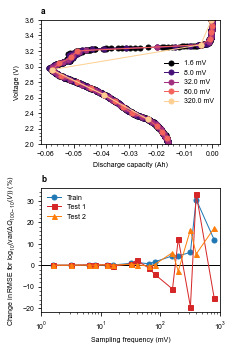

In [21]:
colors = cm.get_cmap('magma')(np.linspace(0, 0.9, 5))

fig, ax = plt.subplots(figsize=(fig_width, 2 * fig_height),
                       nrows=2, ncols=1)
ax = ax.ravel()

ax[0].set_title('a', loc='left', weight='bold')
ax[1].set_title('b', loc='left', weight='bold')

# Panel A: Curves
mV_frequencies_reduced = mV_frequencies[::3]

sample_Qsub = Qsub[:, 98] - Qsub[:, 8] # Q100 - Q10

for k, freq in enumerate(sampling_frequencies[::3]):
    
    ax[0].plot(sample_Qsub[::freq], Vdlin[::freq], '-o',
               color=colors[k], label=f'{mV_frequencies_reduced[k]} mV')

ax[0].set_ylim([2.0, 3.6])
ax[0].set_xlabel('Discharge capacity (Ah)')
ax[0].set_ylabel('Voltage (V)')
ax[0].legend()

# Panel B: RMSE vs frequency
ax[1].semilogx(mV_frequencies, RMSE_train_percent_change, '-o', color='tab:blue', label='Train', zorder=2)
ax[1].semilogx(mV_frequencies, RMSE_test1_percent_change, '-s', color='tab:red', label='Test 1', zorder=2)
ax[1].semilogx(mV_frequencies, RMSE_test2_percent_change, '-^', color='tab:orange', label='Test 2', zorder=2)
ax[1].axhline(0, color='k', zorder=1)
ax[1].set_xlim([1, 1001])
ax[1].set_xlabel('Sampling frequency (mV)')
ax[1].set_ylabel(r'Change in RMSE for $\log_{10}($var$(\Delta Q_{100-10}(V))$ (%)')
ax[1].legend()
    
# Save
plt.tight_layout()
plt.savefig(figpath / 'fig2_sampling_frequency.eps', format='eps')

## Summary statistic features and transformations

Here we try various univariate models, combining different summary statistics with different transforms.

The script is set up so that these lists can be easily modified.

Define summary statistic features to extract from $ \Delta Q_{100-10}(V) $:

In [22]:
functions = {
             '$\Delta Q_{100-10}' + f'({Vdlin[220]:0.3f}$V)':    lambda x: x[:, 220],
             '$\Delta Q_{100-10}' + f'({Vdlin[400]:0.3f}$V)':    lambda x: x[:, 400],
             '$\Delta Q_{100-10}' + f'({Vdlin[-1]:0.3f}$V)':     lambda x: x[:, -1],
             'min($\Delta Q_{100-10}$)' :                        lambda x: np.min(x, axis=1),
             'range($\Delta Q_{100-10}$)' :                      lambda x: np.max(x, axis=1) - np.min(x, axis=1),
             'IDR($\Delta Q_{100-10}$)' :                        lambda x: np.percentile(x, 90, axis=1) - np.percentile(x, 10, axis=1),
             'IQR($\Delta Q_{100-10}$)' :                        lambda x: np.percentile(x, 75, axis=1) - np.percentile(x, 25, axis=1),
             'median($\Delta Q_{100-10}$)':                      lambda x: np.median(x, axis=1),
             'mean($\Delta Q_{100-10}$)':                        lambda x: np.mean(x, axis=1),
             'mean($\Delta Q_{100-10}^2$)':                      lambda x: np.mean(x**2, axis=1),
             'mean($\Delta Q_{100-10}^3$)':                      lambda x: np.mean(x**3, axis=1),
             'var($\Delta Q_{100-10}$)':                         lambda x: np.var(x, axis=1),
             'skew($\Delta Q_{100-10}$)':                        lambda x: skew(x, axis=1),
             'kurt($\Delta Q_{100-10}$)':                        lambda x: kurtosis(x, axis=1),
            }

Define transforms:

In [23]:
transforms = {
              'Original': lambda x: x,
              'sqrt':     lambda x: np.sqrt(np.abs(x)),
              'cbrt':     lambda x: np.cbrt(x),
              'log10':    lambda x: np.log10(np.abs(x)),
             }

Compute $ \Delta Q_{100-10}(V) $:

In [24]:
DeltaQ_100_minus_10_train = data_train[:, :, 98] - data_train[:, :, 8]
DeltaQ_100_minus_10_test1 = data_test1_mod[:, :, 98] - data_test1_mod[:, :, 8]
DeltaQ_100_minus_10_test2 = data_test2[:, :, 98] - data_test2[:, :, 8]

Loop through all summary statistic features and transforms to train the model and evaluate test error:

$\Delta Q_{100-10}(3.248$V)
Original: Skew(train) = -1.042, RMSE(train) = 263.869
sqrt: Skew(train) = 0.225, RMSE(train) = 251.197
cbrt: Skew(train) = 0.024, RMSE(train) = 247.284
log10: Skew(train) = -0.476, RMSE(train) = 240.209

$\Delta Q_{100-10}(2.959$V)
Original: Skew(train) = -1.190, RMSE(train) = 213.081
sqrt: Skew(train) = -0.098, RMSE(train) = 137.543
cbrt: Skew(train) = 0.541, RMSE(train) = 120.238
log10: Skew(train) = -1.470, RMSE(train) = 112.607

$\Delta Q_{100-10}(2.000$V)
Original: Skew(train) = -3.151, RMSE(train) = 290.926
sqrt: Skew(train) = 1.113, RMSE(train) = 255.141
cbrt: Skew(train) = 1.310, RMSE(train) = 294.164
log10: Skew(train) = -0.917, RMSE(train) = 250.589

min($\Delta Q_{100-10}$)
Original: Skew(train) = -1.791, RMSE(train) = 236.721
sqrt: Skew(train) = 0.441, RMSE(train) = 164.089
cbrt: Skew(train) = -0.015, RMSE(train) = 145.517
log10: Skew(train) = -0.801, RMSE(train) = 115.531

range($\Delta Q_{100-10}$)
Original: Skew(train) = 1.803, RMSE(train) = 2

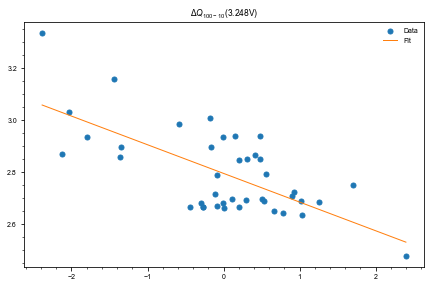

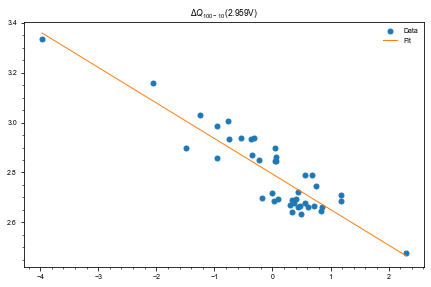

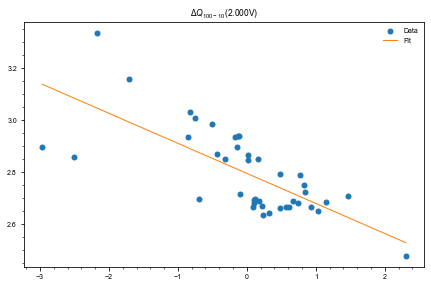

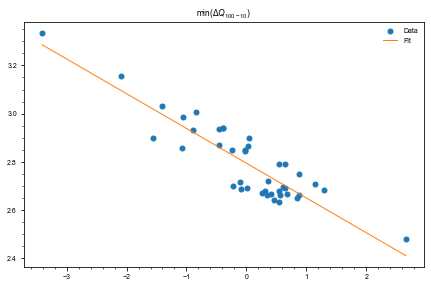

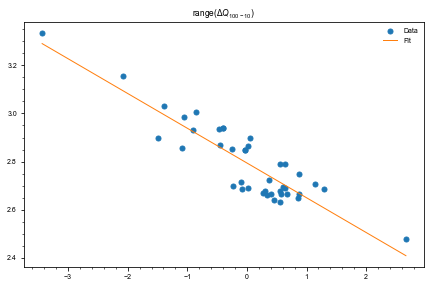

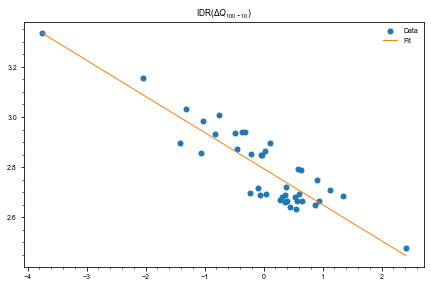

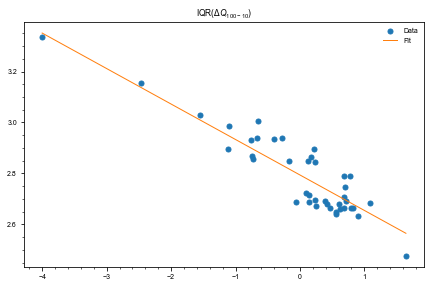

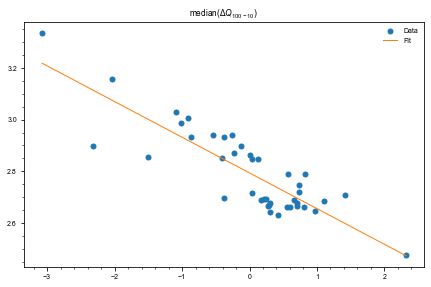

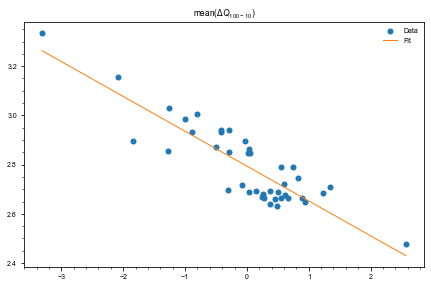

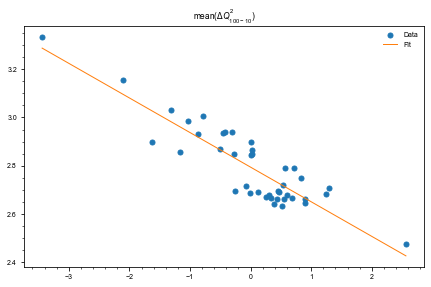

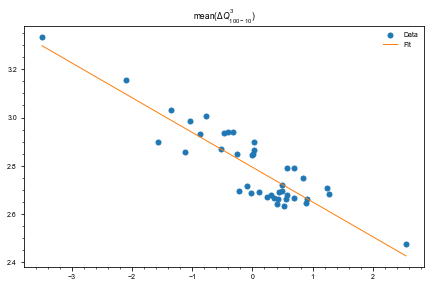

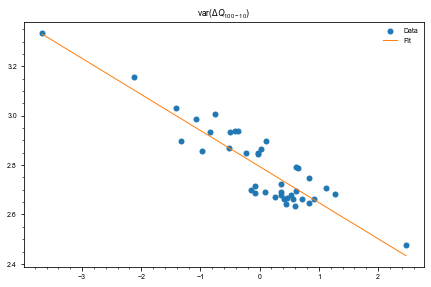

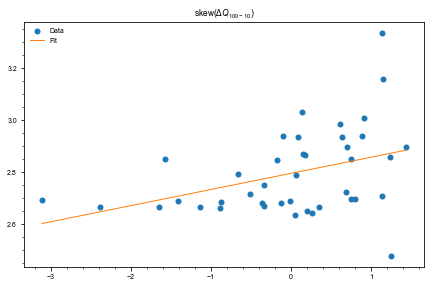

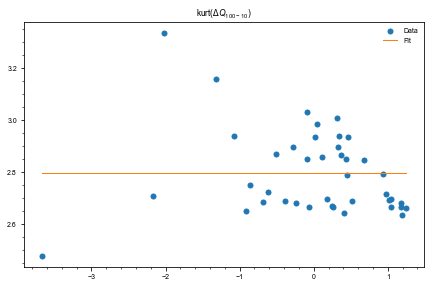

In [25]:
# Preinitialize
RMSE_train = np.zeros((len(functions), len(transforms)))
RMSE_test1 = np.zeros((len(functions), len(transforms)))
RMSE_test2 = np.zeros((len(functions), len(transforms)))
skews = np.zeros((len(functions), len(transforms)))

# Preinitialize
do_raw_features_have_consistently_signed_values = {}

# Loop
for k, func in enumerate(functions):
    
    print(func)
    
    for k2, trans in enumerate(transforms):
        
        # Apply summary statistic to get a single feature per cell
        X_train = functions[func](DeltaQ_100_minus_10_train)
        X_test1 = functions[func](DeltaQ_100_minus_10_test1)
        X_test2 = functions[func](DeltaQ_100_minus_10_test2)
        
        if trans == 'Original':
            do_raw_features_have_consistently_signed_values[func] = (np.sign(np.min(X_train)) == np.sign(np.max(X_train)) and
                                                                     np.sign(np.min(X_test1)) == np.sign(np.max(X_test1)) and
                                                                     np.sign(np.min(X_test2)) == np.sign(np.max(X_test2)))
        else: # apply transform
            transform = transforms[trans]
            X_train, X_test1, X_test2 = transform(X_train), transform(X_test1), transform(X_test2)

        # Scale via standarization
        scaler = preprocessing.StandardScaler().fit(X_train.reshape(-1, 1))
        X_train_scaled = scaler.transform(X_train.reshape(-1, 1))
        X_test1_scaled = scaler.transform(X_test1.reshape(-1, 1))
        X_test2_scaled = scaler.transform(X_test2.reshape(-1, 1))
        
        # Define and fit linear regression via enet
        enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0)
        enet.fit(X_train_scaled, y_train)
        
        # Predict on test sets
        y_train_pred = enet.predict(X_train_scaled)
        y_test1_pred = enet.predict(X_test1_scaled)
        y_test2_pred = enet.predict(X_test2_scaled)

        RMSE_train[k, k2] = mean_squared_error(np.power(10, y_train), np.power(10, y_train_pred), squared=False)
        RMSE_test1[k, k2] = mean_squared_error(np.power(10, y_test1_mod), np.power(10, y_test1_pred), squared=False)
        RMSE_test2[k, k2] = mean_squared_error(np.power(10, y_test2), np.power(10, y_test2_pred), squared=False)

        # Print stats
        skews[k, k2] = skew(X_train)
        print(f'{trans}: Skew(train) = {skews[k, k2]:0.3f}, RMSE(train) = {RMSE_train[k, k2]:0.3f}')
    
    print()
    
    # make plot for last transformation
    X_fit = np.linspace(np.min(X_train_scaled), np.max(X_train_scaled), 100)
    y_fit = X_fit * enet.coef_[0] + enet.intercept_
    
    plt.figure()
    plt.plot(X_train_scaled, y_train, 'o', label='Data')
    plt.plot(X_fit, y_fit, label='Fit')
    plt.title(func)
    plt.legend()

Just for fun, here's a quick plot of RMSE vs `skews`:

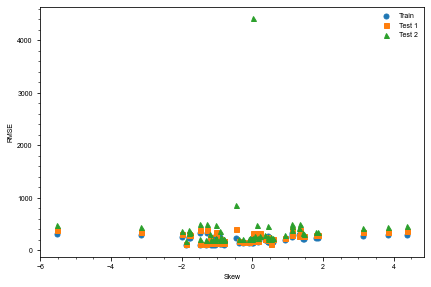

In [26]:
plt.plot(skews.ravel(), RMSE_train.ravel(), 'o', label='Train')
plt.plot(skews.ravel(), RMSE_test1.ravel(), 's', label='Test 1')
plt.plot(skews.ravel(), RMSE_test2.ravel(), '^', label='Test 2')

plt.xlabel('Skew')
plt.ylabel('RMSE')
plt.legend()

Slight correlation but not that interesting.

Plot heat map:

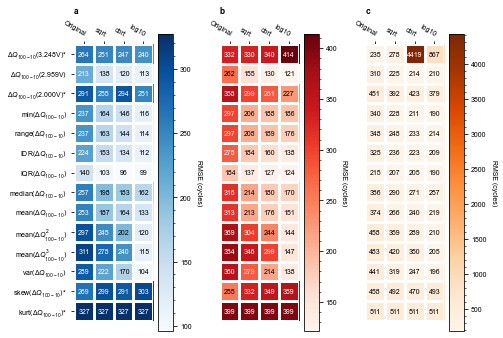

In [27]:
fig, ax = plt.subplots(figsize=(fig_width_2col, 2*fig_height),
                       nrows=1, ncols=3)

ax[0].set_title('a', loc='left', weight='bold')
ax[1].set_title('b', loc='left', weight='bold')
ax[2].set_title('c', loc='left', weight='bold')

# Add astrisk to functions without consistently signed values
functions_list = list(functions.keys())
for k, func in enumerate(functions_list):
    if not do_raw_features_have_consistently_signed_values[func]: 
        functions_list[k] = func + '*'

transforms_list = list(transforms.keys())

im, cbar = heatmap(RMSE_train, row_labels=functions_list, col_labels=transforms_list, ax=ax[0],
                   cmap="Blues", cbarlabel="RMSE (cycles)")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

im, cbar = heatmap(RMSE_test1, col_labels=transforms_list, ax=ax[1],
                   cmap="Reds", cbarlabel="RMSE (cycles)")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

im, cbar = heatmap(RMSE_test2, col_labels=transforms_list, ax=ax[2],
                   cmap="Oranges", cbarlabel="RMSE (cycles)")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

plt.tight_layout()
plt.savefig(figpath / 'fig3_univariate_heatmap.eps', format='eps')

## Linear cycle life

Repeat analysis but use linear cycle life instead of logged cycle life.

Loop through all summary statistic features and transforms to train the model and evaluate test error:

In [28]:
# Preinitialize
RMSE_train = np.zeros((len(functions), len(transforms)))
RMSE_test1 = np.zeros((len(functions), len(transforms)))
RMSE_test2 = np.zeros((len(functions), len(transforms)))
skews = np.zeros((len(functions), len(transforms)))

# Preinitialize
do_raw_features_have_consistently_signed_values = {}

# Loop
for k, func in enumerate(functions):
    
    print(func)
    
    for k2, trans in enumerate(transforms):
        
        # Apply summary statistic to get a single feature per cell
        X_train = functions[func](DeltaQ_100_minus_10_train)
        X_test1 = functions[func](DeltaQ_100_minus_10_test1)
        X_test2 = functions[func](DeltaQ_100_minus_10_test2)
        
        if trans == 'Original':
            do_raw_features_have_consistently_signed_values[func] = (np.sign(np.min(X_train)) == np.sign(np.max(X_train)) and
                                                                     np.sign(np.min(X_test1)) == np.sign(np.max(X_test1)) and
                                                                     np.sign(np.min(X_test2)) == np.sign(np.max(X_test2)))
        else: # apply transform
            transform = transforms[trans]
            X_train, X_test1, X_test2 = transform(X_train), transform(X_test1), transform(X_test2)

        # Scale via standarization
        scaler = preprocessing.StandardScaler().fit(X_train.reshape(-1, 1))
        X_train_scaled = scaler.transform(X_train.reshape(-1, 1))
        X_test1_scaled = scaler.transform(X_test1.reshape(-1, 1))
        X_test2_scaled = scaler.transform(X_test2.reshape(-1, 1))
        
        # Define and fit linear regression via enet
        enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0)
        enet.fit(X_train_scaled, cycle_lives_train)
        
        # Predict on test sets
        y_train_pred = enet.predict(X_train_scaled)
        y_test1_pred = enet.predict(X_test1_scaled)
        y_test2_pred = enet.predict(X_test2_scaled)

        RMSE_train[k, k2] = mean_squared_error(cycle_lives_train, y_train_pred, squared=False)
        RMSE_test1[k, k2] = mean_squared_error(cycle_lives_test1_mod, y_test1_pred, squared=False)
        RMSE_test2[k, k2] = mean_squared_error(cycle_lives_test2, y_test2_pred, squared=False)

        # Print stats
        skews[k, k2] = skew(X_train)
        print(f'{trans}: Skew(train) = {skews[k, k2]:0.3f}, RMSE(train) = {RMSE_train[k, k2]:0.3f}')
        
    print()

$\Delta Q_{100-10}(3.248$V)
Original: Skew(train) = -1.042, RMSE(train) = 267.901
sqrt: Skew(train) = 0.225, RMSE(train) = 255.847
cbrt: Skew(train) = 0.024, RMSE(train) = 251.998
log10: Skew(train) = -0.476, RMSE(train) = 244.861

$\Delta Q_{100-10}(2.959$V)
Original: Skew(train) = -1.190, RMSE(train) = 232.354
sqrt: Skew(train) = -0.098, RMSE(train) = 180.658
cbrt: Skew(train) = 0.541, RMSE(train) = 165.173
log10: Skew(train) = -1.470, RMSE(train) = 135.455

$\Delta Q_{100-10}(2.000$V)
Original: Skew(train) = -3.151, RMSE(train) = 289.392
sqrt: Skew(train) = 1.113, RMSE(train) = 260.299
cbrt: Skew(train) = 1.310, RMSE(train) = 272.359
log10: Skew(train) = -0.917, RMSE(train) = 240.885

min($\Delta Q_{100-10}$)
Original: Skew(train) = -1.791, RMSE(train) = 248.278
sqrt: Skew(train) = 0.441, RMSE(train) = 203.054
cbrt: Skew(train) = -0.015, RMSE(train) = 185.744
log10: Skew(train) = -0.801, RMSE(train) = 157.781

range($\Delta Q_{100-10}$)
Original: Skew(train) = 1.803, RMSE(train) = 2

Plot heat map:

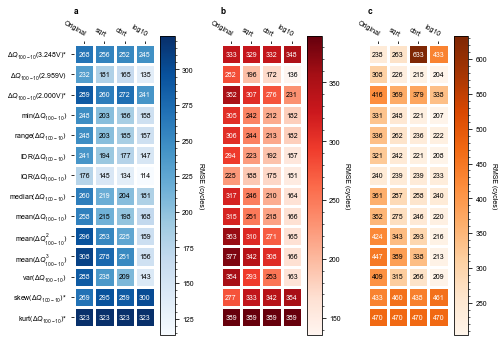

In [29]:
fig, ax = plt.subplots(figsize=(fig_width_2col, 2*fig_height),
                       nrows=1, ncols=3)

ax[0].set_title('a', loc='left', weight='bold')
ax[1].set_title('b', loc='left', weight='bold')
ax[2].set_title('c', loc='left', weight='bold')

# Add astrisk to functions without consistently signed values
functions_list = list(functions.keys())
for k, func in enumerate(functions_list):
    if not do_raw_features_have_consistently_signed_values[func]: 
        functions_list[k] = func + '*'

transforms_list = list(transforms.keys())

im, cbar = heatmap(RMSE_train, row_labels=functions_list, col_labels=transforms_list, ax=ax[0],
                   cmap="Blues", cbarlabel="RMSE (cycles)")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

im, cbar = heatmap(RMSE_test1, col_labels=transforms_list, ax=ax[1],
                   cmap="Reds", cbarlabel="RMSE (cycles)")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

im, cbar = heatmap(RMSE_test2, col_labels=transforms_list, ax=ax[2],
                   cmap="Oranges", cbarlabel="RMSE (cycles)")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

plt.tight_layout()
plt.savefig(figpath / 'fig4_univariate_heatmap_linear_cycle_life.eps', format='eps')

## Cycle number averaging (e.g. $ \Delta Q_{(98:100)-(9:11)}(V) $ )

For $ \Delta Q_{100-10}(V) $, we are only using two of the available 100 cycles.
This approach is "wasteful" as it doesn't consider similar neighboring cycles.
In this section, we try local averaging over multiple cycles to see if this reduces the noise and improves the predictions.

We use cycles 9, 10, and 11 for the initial cycles and 98, 99, and 100 for the final cycles (to make sure that we still use the first 100 cycles).

In [30]:
functions = {
             '$\Delta Q_{98:100-9:11}' + f'({Vdlin[220]:0.3f}$V)':    lambda x: x[:, 220],
             '$\Delta Q_{98:100-9:11}' + f'({Vdlin[400]:0.3f}$V)':    lambda x: x[:, 400],
             '$\Delta Q_{98:100-9:11}' + f'({Vdlin[-1]:0.3f}$V)':     lambda x: x[:, -1],
             'min($\Delta Q_{98:100-9:11}$)' :                        lambda x: np.min(x, axis=1),
             'range($\Delta Q_{98:100-9:11}$)' :                      lambda x: np.max(x, axis=1) - np.min(x, axis=1),
             'IDR($\Delta Q_{98:100-9:11}$)' :                        lambda x: np.percentile(x, 90, axis=1) - np.percentile(x, 10, axis=1),
             'IQR($\Delta Q_{98:100-9:11}$)' :                        lambda x: np.percentile(x, 75, axis=1) - np.percentile(x, 25, axis=1),
             'median($\Delta Q_{98:100-9:11}$)':                      lambda x: np.median(x, axis=1),
             'mean($\Delta Q_{98:100-9:11}$)':                        lambda x: np.mean(x, axis=1),
             'mean($\Delta Q_{98:100-9:11}^2$)':                      lambda x: np.mean(x**2, axis=1),
             'mean($\Delta Q_{98:100-9:11}^3$)':                      lambda x: np.mean(x**3, axis=1),
             'var($\Delta Q_{98:100-9:11}$)':                         lambda x: np.var(x, axis=1),
             'skew($\Delta Q_{98:100-9:11}$)':                        lambda x: skew(x, axis=1),
             'kurt($\Delta Q_{98:100-9:11}$)':                        lambda x: kurtosis(x, axis=1),
            }

Find $ \Delta Q_{(98:100)-(9:11)}(V) $:

In [31]:
DeltaQ_100_minus_10_train_cycavg = np.mean(data_train[:, :, 96:99], axis=2) - np.mean(data_train[:, :, 7:10], axis=2)
DeltaQ_100_minus_10_test1_cycavg = np.mean(data_test1_mod[:, :, 96:99], axis=2) - np.mean(data_test1_mod[:, :, 7:10], axis=2)
DeltaQ_100_minus_10_test2_cycavg = np.mean(data_test2[:, :, 96:99], axis=2) - np.mean(data_test2[:, :, 7:10], axis=2)

Loop through all summary statistic features and transforms to train the model and evaluate test error:

In [32]:
# Preinitialize
RMSE_train = np.zeros((len(functions), len(transforms)))
RMSE_test1 = np.zeros((len(functions), len(transforms)))
RMSE_test2 = np.zeros((len(functions), len(transforms)))
skews = np.zeros((len(functions), len(transforms)))

# Preinitialize
do_raw_features_have_consistently_signed_values = {}

# Loop
for k, func in enumerate(functions):
    
    print(func)
    
    for k2, trans in enumerate(transforms):
        
        # Apply summary statistic to get a single feature per cell
        X_train = functions[func](DeltaQ_100_minus_10_train_cycavg)
        X_test1 = functions[func](DeltaQ_100_minus_10_test1_cycavg)
        X_test2 = functions[func](DeltaQ_100_minus_10_test2_cycavg)
        
        if trans == 'Original':
            do_raw_features_have_consistently_signed_values[func] = (np.sign(np.min(X_train)) == np.sign(np.max(X_train)) and
                                                                     np.sign(np.min(X_test1)) == np.sign(np.max(X_test1)) and
                                                                     np.sign(np.min(X_test2)) == np.sign(np.max(X_test2)))
        else: # apply transform
            transform = transforms[trans]
            X_train, X_test1, X_test2 = transform(X_train), transform(X_test1), transform(X_test2)

        # Scale via standarization
        scaler = preprocessing.StandardScaler().fit(X_train.reshape(-1, 1))
        X_train_scaled = scaler.transform(X_train.reshape(-1, 1))
        X_test1_scaled = scaler.transform(X_test1.reshape(-1, 1))
        X_test2_scaled = scaler.transform(X_test2.reshape(-1, 1))
        
        # Define and fit linear regression via enet
        enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0)
        enet.fit(X_train_scaled, y_train)
        
        # Predict on test sets
        y_train_pred = enet.predict(X_train_scaled)
        y_test1_pred = enet.predict(X_test1_scaled)
        y_test2_pred = enet.predict(X_test2_scaled)

        RMSE_train[k, k2] = mean_squared_error(np.power(10, y_train), np.power(10, y_train_pred), squared=False)
        RMSE_test1[k, k2] = mean_squared_error(np.power(10, y_test1_mod), np.power(10, y_test1_pred), squared=False)
        RMSE_test2[k, k2] = mean_squared_error(np.power(10, y_test2), np.power(10, y_test2_pred), squared=False)

        # Print stats
        skews[k, k2] = skew(X_train)
        print(f'{trans}: Skew(train) = {skews[k, k2]:0.3f}, RMSE(train) = {RMSE_train[k, k2]:0.3f}')
        
    print()

$\Delta Q_{98:100-9:11}(3.248$V)
Original: Skew(train) = -1.217, RMSE(train) = 269.383
sqrt: Skew(train) = 0.247, RMSE(train) = 250.183
cbrt: Skew(train) = 0.064, RMSE(train) = 243.138
log10: Skew(train) = -0.652, RMSE(train) = 228.576

$\Delta Q_{98:100-9:11}(2.959$V)
Original: Skew(train) = -1.163, RMSE(train) = 209.550
sqrt: Skew(train) = -0.133, RMSE(train) = 134.749
cbrt: Skew(train) = 0.572, RMSE(train) = 117.701
log10: Skew(train) = -1.479, RMSE(train) = 109.825

$\Delta Q_{98:100-9:11}(2.000$V)
Original: Skew(train) = -3.291, RMSE(train) = 291.915
sqrt: Skew(train) = 1.198, RMSE(train) = 256.713
cbrt: Skew(train) = 1.285, RMSE(train) = 294.781
log10: Skew(train) = -0.883, RMSE(train) = 252.034

min($\Delta Q_{98:100-9:11}$)
Original: Skew(train) = -1.635, RMSE(train) = 228.696
sqrt: Skew(train) = 0.207, RMSE(train) = 149.761
cbrt: Skew(train) = 0.268, RMSE(train) = 130.436
log10: Skew(train) = -1.224, RMSE(train) = 111.775

range($\Delta Q_{98:100-9:11}$)
Original: Skew(train) 

Plot heat map:

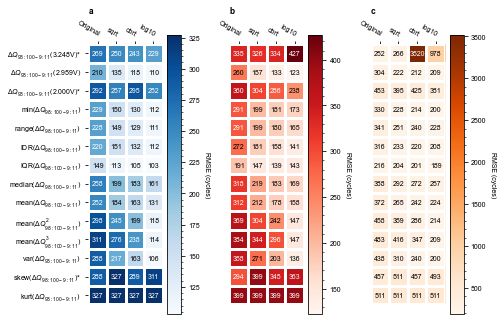

In [33]:
fig, ax = plt.subplots(figsize=(fig_width_2col, 2*fig_height),
                       nrows=1, ncols=3)

ax[0].set_title('a', loc='left', weight='bold')
ax[1].set_title('b', loc='left', weight='bold')
ax[2].set_title('c', loc='left', weight='bold')

# Add astrisk to functions without consistently signed values
functions_list = list(functions.keys())
for k, func in enumerate(functions_list):
    if not do_raw_features_have_consistently_signed_values[func]: 
        functions_list[k] = func + '*'

transforms_list = list(transforms.keys())

im, cbar = heatmap(RMSE_train, row_labels=functions_list, col_labels=transforms_list, ax=ax[0],
                   cmap="Blues", cbarlabel="RMSE (cycles)")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

im, cbar = heatmap(RMSE_test1, col_labels=transforms_list, ax=ax[1],
                   cmap="Reds", cbarlabel="RMSE (cycles)")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

im, cbar = heatmap(RMSE_test2, col_labels=transforms_list, ax=ax[2],
                   cmap="Oranges", cbarlabel="RMSE (cycles)")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

plt.tight_layout()
plt.savefig(figpath / 'fig5_univariate_heatmap_local_cycle_averaging.eps', format='eps')

## Single-point voltage prediction

Here, we evaluate the predictive capability of single elements in the voltage array.
Specifically, we evaluate the predictive ability of $ \Delta Q_{100-10}(V) $ at different values of voltage. Fair warning, this block takes a while to run.

In [34]:
# Preinitialize
RMSE_train = np.zeros((data_train.shape[1], len(transforms)))
RMSE_test1 = np.zeros((data_test1_mod.shape[1], len(transforms)))
RMSE_test2 = np.zeros((data_test2.shape[1], len(transforms)))

# Loop
for k in np.arange(1000):
    
    if k % 50 == 0:
        print(f'Starting {k}/1000 ({k/10:.0f}%)')
        
    for k2, trans in enumerate(transforms):
        
        # Q_{100 - 10} at different voltages
        X_train = data_train[:, k, 98] - data_train[:, k, 8]
        X_test1 = data_test1_mod[:, k, 98] - data_test1_mod[:, k, 8]
        X_test2 = data_test2[:, k, 98] - data_test2[:, k, 8]
        
        # apply transform
        transform = transforms[trans]
        X_train, X_test1, X_test2 = transform(X_train), transform(X_test1), transform(X_test2)

        # Skip if nonfinite values
        if not np.isfinite(X_train).all() or not np.isfinite(X_test1).all() or not np.isfinite(X_test2).all():
            RMSE_train[k, k2] = np.nan
            RMSE_test1[k, k2] = np.nan
            RMSE_test2[k, k2] = np.nan

        else:
            # Scale via standarization
            scaler = preprocessing.StandardScaler().fit(X_train.reshape(-1, 1))
            X_train_scaled = scaler.transform(X_train.reshape(-1, 1))
            X_test1_scaled = scaler.transform(X_test1.reshape(-1, 1))
            X_test2_scaled = scaler.transform(X_test2.reshape(-1, 1))

            # Define and fit linear regression via enet
            enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0)
            enet.fit(X_train_scaled, y_train)

            # Predict on test sets
            y_train_pred = enet.predict(X_train_scaled)
            y_test1_pred = enet.predict(X_test1_scaled)
            y_test2_pred = enet.predict(X_test2_scaled)

            RMSE_train[k, k2] = mean_squared_error(np.power(10, y_train), np.power(10, y_train_pred), squared=False)
            RMSE_test1[k, k2] = mean_squared_error(np.power(10, y_test1_mod), np.power(10, y_test1_pred), squared=False)
            RMSE_test2[k, k2] = mean_squared_error(np.power(10, y_test2), np.power(10, y_test2_pred), squared=False)

Starting 0/1000 (0%)


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


Starting 50/1000 (5%)
Starting 100/1000 (10%)


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


Starting 150/1000 (15%)


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


Starting 200/1000 (20%)
Starting 250/1000 (25%)
Starting 300/1000 (30%)
Starting 350/1000 (35%)
Starting 400/1000 (40%)
Starting 450/1000 (45%)
Starting 500/1000 (50%)
Starting 550/1000 (55%)
Starting 600/1000 (60%)
Starting 650/1000 (65%)
Starting 700/1000 (70%)
Starting 750/1000 (75%)
Starting 800/1000 (80%)
Starting 850/1000 (85%)


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_l

Starting 900/1000 (90%)


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_l

Starting 950/1000 (95%)


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


Make plot:

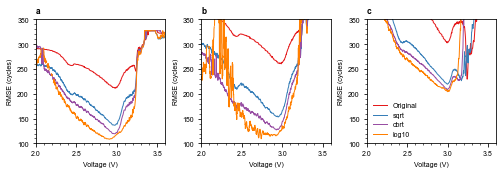

In [35]:
transform_colors = cm.get_cmap('Set1')([0, 1, 3, 4])[:,:3]

fig, ax = plt.subplots(figsize=(fig_width_2col, fig_height), nrows=1, ncols=3)
ax = ax.ravel()

for k in range(len(transforms)):
    ax[0].plot(Vdlin, RMSE_train[:,k], color=transform_colors[k])
    ax[1].plot(Vdlin, RMSE_test1[:,k], color=transform_colors[k])
    ax[2].plot(Vdlin, RMSE_test2[:,k], color=transform_colors[k])

for k in np.arange(3):
    ax[k].set_title(chr(97+k), loc='left', weight='bold')
    ax[k].set_xlim([2, 3.6])
    ax[k].set_ylim([100, 350])
    ax[k].set_xlabel('Voltage (V)')
    ax[k].set_ylabel('RMSE (cycles)')

ax[2].legend(transforms_list)
    
plt.tight_layout()
plt.savefig(figpath / 'fig6_single_point_prediction.eps', format='eps')

What is the minimum RMSE values for the log10 model (index=3)?

In [36]:
np.nanmin(RMSE_train[:,3]), np.nanmin(RMSE_test1[:,3]), np.nanmin(RMSE_test2[:,3])

(108.52252076816332, 109.4511374415956, 204.40718447050574)

Voltages at which they occur:

In [37]:
Vdlin[np.nanargmin(RMSE_train[:,3])], Vdlin[np.nanargmin(RMSE_test1[:,3])], Vdlin[np.nanargmin(RMSE_test2[:,3])]

(2.9113113113113114, 2.7415415415415416, 2.997797797797798)

What are the test errors if we evaluate at the voltage that minimizes the training error?

In [38]:
idx_train_min_error = np.nanargmin(RMSE_train[:,3])
RMSE_train[idx_train_min_error,3], RMSE_test1[idx_train_min_error,3], RMSE_test2[idx_train_min_error,3]

(108.52252076816332, 118.23241306995492, 213.64182434018463)

## Multivariate model from univariate $\Delta Q_{100-10}(V)$ features

This section isn't discussed in depth in the paper, but here I tried to build a multivariate model with the $\Delta Q_{100-10}(V)$ features that don't require the absolute value function (i.e. the highest-performing features).

In [39]:
functions = {
             '$\Delta Q_{100-10}' + f'({Vdlin[400]:0.3f}$V)':    lambda x: x[:, 400],
             'min($\Delta Q_{100-10}$)' :                        lambda x: np.min(x, axis=1),
             'range($\Delta Q_{100-10}$)' :                      lambda x: np.max(x, axis=1) - np.min(x, axis=1),
             'IDR($\Delta Q_{100-10}$)' :                        lambda x: np.percentile(x, 90, axis=1) - np.percentile(x, 10, axis=1),
             'IQR($\Delta Q_{100-10}$)' :                        lambda x: np.percentile(x, 75, axis=1) - np.percentile(x, 25, axis=1),
             'median($\Delta Q_{100-10}$)':                      lambda x: np.median(x, axis=1),
             'mean($\Delta Q_{100-10}$)':                        lambda x: np.mean(x, axis=1),
             'mean($\Delta Q_{100-10}^2$)':                      lambda x: np.mean(x**2, axis=1),
             'mean($\Delta Q_{100-10}^3$)':                      lambda x: np.mean(x**3, axis=1),
             'var($\Delta Q_{100-10}$)':                         lambda x: np.var(x, axis=1),
            }

Loop through all summary statistic features and transforms to train the model and evaluate test error:

In [40]:
# Preinitialize
RMSE_train = np.zeros((len(transforms), ))
RMSE_test1 = np.zeros((len(transforms), ))
RMSE_test2 = np.zeros((len(transforms), ))

X_train = np.zeros((len(DeltaQ_100_minus_10_train), len(functions)))
X_test1 = np.zeros((len(DeltaQ_100_minus_10_test1), len(functions)))
X_test2 = np.zeros((len(DeltaQ_100_minus_10_test2), len(functions)))

# Loop
for k, trans in enumerate(transforms):

    for k2, func in enumerate(functions):    

        # Apply summary statistic to get a single feature per cell
        X_train[:, k2] = functions[func](DeltaQ_100_minus_10_train)
        X_test1[:, k2] = functions[func](DeltaQ_100_minus_10_test1)
        X_test2[:, k2] = functions[func](DeltaQ_100_minus_10_test2)

    # Apply transform
    transform = transforms[trans]
    X_train, X_test1, X_test2 = transform(X_train), transform(X_test1), transform(X_test2)

    # Scale via standarization
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test1_scaled = scaler.transform(X_test1)
    X_test2_scaled = scaler.transform(X_test2)

    # Define and fit linear regression via enet
    enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0, max_iter=100000)
    enet.fit(X_train_scaled, y_train)

    # Predict on test sets
    y_train_pred = enet.predict(X_train_scaled)
    y_test1_pred = enet.predict(X_test1_scaled)
    y_test2_pred = enet.predict(X_test2_scaled)

    RMSE_train[k] = mean_squared_error(np.power(10, y_train), np.power(10, y_train_pred), squared=False)
    RMSE_test1[k] = mean_squared_error(np.power(10, y_test1_mod), np.power(10, y_test1_pred), squared=False)
    RMSE_test2[k] = mean_squared_error(np.power(10, y_test2), np.power(10, y_test2_pred), squared=False)

    print(f'{trans}: RMSE_train={RMSE_train[k]:.0f}, RMSE_test1={RMSE_test1[k]:.0f}, RMSE_test2={RMSE_test2[k]:.0f}')

Original: RMSE_train=138, RMSE_test1=183, RMSE_test2=214
sqrt: RMSE_train=105, RMSE_test1=138, RMSE_test2=201
cbrt: RMSE_train=97, RMSE_test1=125, RMSE_test2=196
log10: RMSE_train=99, RMSE_test1=133, RMSE_test2=185


Overall, these models are comparable to the simpler univariate models. Why? Probably because the features are highly correlated:

In [41]:
corr = pd.DataFrame(X_train, columns=functions.keys()).corr()
corr.style.background_gradient(cmap='coolwarm')

,$\Delta Q_{100-10}(2.959$V),min($\Delta Q_{100-10}$),range($\Delta Q_{100-10}$),IDR($\Delta Q_{100-10}$),IQR($\Delta Q_{100-10}$),median($\Delta Q_{100-10}$),mean($\Delta Q_{100-10}$),mean($\Delta Q_{100-10}^2$),mean($\Delta Q_{100-10}^3$),var($\Delta Q_{100-10}$)
$\Delta Q_{100-10}(2.959$V),1.000000,0.990109,0.990367,0.995774,0.969571,0.970390,0.987988,0.992791,0.993967,0.995126
min($\Delta Q_{100-10}$),0.990109,1.000000,0.999927,0.995904,0.953506,0.975214,0.994191,0.997429,0.998160,0.996241
range($\Delta Q_{100-10}$),0.990367,0.999927,1.000000,0.996213,0.953767,0.974065,0.993635,0.997213,0.998051,0.996539
IDR($\Delta Q_{100-10}$),0.995774,0.995904,0.996213,1.000000,0.964969,0.967683,0.990175,0.995537,0.997291,0.998783
IQR($\Delta Q_{100-10}$),0.969571,0.953506,0.953767,0.964969,1.000000,0.912619,0.940378,0.952525,0.957425,0.971181
median($\Delta Q_{100-10}$),0.970390,0.975214,0.974065,0.967683,0.912619,1.000000,0.991010,0.984013,0.979859,0.964653
mean($\Delta Q_{100-10}$),0.987988,0.994191,0.993635,0.990175,0.940378,0.991010,1.000000,0.998635,0.997117,0.988781
mean($\Delta Q_{100-10}^2$),0.992791,0.997429,0.997213,0.995537,0.952525,0.984013,0.998635,1.000000,0.999698,0.995136
mean($\Delta Q_{100-10}^3$),0.993967,0.998160,0.998051,0.997291,0.957425,0.979859,0.997117,0.999698,1.000000,0.997203
var($\Delta Q_{100-10}$),0.995126,0.996241,0.996539,0.998783,0.971181,0.964653,0.988781,0.995136,0.997203,1.000000


Yea, they are. What is the median correlation coefficient?

In [42]:
corr.median().median()

0.9957639402918929

0.996 is quite high. So these features are generally redundant with each other, which explains why the multivariate model isn't much better than univariate models.

Interestingly, the corerlation between between the IQR and variance features (the two best performing features) is 0.971, which is lower than the median.

## Learning from the raw features in $ \Delta Q_{100-10}(V) $

In Severson et al. and previous sections, we used summary statistics of $ \Delta Q_{100-10}(V) $ as features for training. In this section, we consider using the raw Q-V pairs as the features instead of the summary statistics. The primary motivation is to aid interpretability by investigating the weights assigned to the various voltages, but this may also improve prediction.

### Define X matrices

Here, each feature is $ \Delta Q_{100-10}(V) $ for a range of voltages.

Note that we use every 10th voltage point in the 1000-point vector (aka 100 points total). I had trouble with elastic net convergence with the full 1000 points. The RMSE for ridge and PLS regression was insensitive to this choice.

In [43]:
# Define sampling frequency
freq = 10

# Define X matrices
X_train = DeltaQ_100_minus_10_train[:, ::freq]
X_test1 = DeltaQ_100_minus_10_test1[:, ::freq]
X_test2 = DeltaQ_100_minus_10_test2[:, ::freq]

# Define X matrices for cyc averaged
X_train_cycavg = DeltaQ_100_minus_10_train_cycavg[:, ::freq]
X_test1_cycavg = DeltaQ_100_minus_10_test1_cycavg[:, ::freq]
X_test2_cycavg = DeltaQ_100_minus_10_test2_cycavg[:, ::freq]

# Scale via standarization
scaler = preprocessing.StandardScaler().fit(X_train)
scaler_cycavg = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test1_scaled = scaler.transform(X_test1)
X_test2_scaled = scaler.transform(X_test2)

X_train_scaled_cycavg = scaler.transform(X_train_cycavg)
X_test1_scaled_cycavg = scaler.transform(X_test1_cycavg)
X_test2_scaled_cycavg = scaler.transform(X_test2_cycavg)

### Hyperparameter optimization

For the ML methods that don't have methods for automatic hyperparamter optimization via cross-validation, we optimize the hyperparameters up front.

#### PLSR

There's only one hyperparameter here, so the optimization is easy. The below function was adapted from [this page](https://nirpyresearch.com/partial-least-squares-regression-python/).

In [44]:
def optimise_pls_cv(X, y, max_comps=20, plot_components=True):
    """
    Run PLS including a variable number of components, up to max_comps,
    and calculate MSE
    """
    
    components = np.arange(1, max_comps + 1).astype('uint8')
    rmse = np.zeros((len(components), ))
    
    # Loop through all possibilities
    for comp in components:
        pls = PLSRegression(n_components=comp)
        
        # Cross-validation
        y_cv = cross_val_predict(pls, X, 10**y, cv=5)
        rmse[comp - 1] = mean_squared_error(10**y, y_cv, squared=False)
    
    rmsemin = np.argmin(rmse)
    print("Suggested number of components: ", rmsemin+1)
    
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.figure()
            plt.plot(components, rmse, '-v', color = 'blue', mfc='blue')
            plt.plot(components[rmsemin], rmse[rmsemin], 'P', ms=10, mfc='red')
            
            plt.xticks(components)
            plt.xlabel('Number of PLS components')
            plt.ylabel('RMSE (cycles)')
            plt.title('PLS')
            plt.xlim(left=-1)
    
    return rmsemin + 1

Find the optimal number of PLS components:

Suggested number of components:  9
Suggested number of components:  8


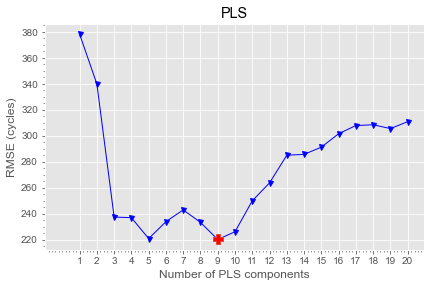

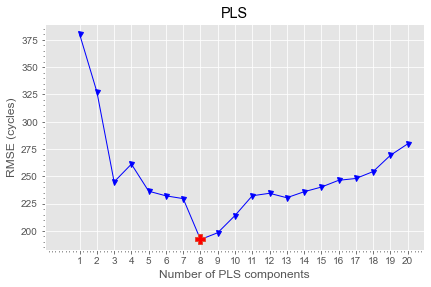

In [45]:
n_comp_plsr = optimise_pls_cv(X_train_scaled, y_train)
n_comp_plsr_cycavg = optimise_pls_cv(X_train_scaled_cycavg, y_train)

### PCR

Similar for PCR, only 1 hyperparameter. Somehow there's no PCR implementation in sklearn

In [46]:
def optimise_pcr_cv(X, y, max_comps=20, plot_components=True):
    """
    Adapted from:
    https://www.kaggle.com/phamvanvung/principal-component-regression/code
    """
    
    # Define the PCA object
    pca = PCA()
    
    # Run PCA producing the reduced variable Xreg and select the first pc components
    Xreg_allcomps = pca.fit_transform(X)
    
    # Define components and preinitialization
    components = np.arange(1, max_comps + 1).astype('uint8')
    rmse = np.zeros((len(components), ))
    
    # Loop through all possibilities
    for comp in components:
    
        Xreg = Xreg_allcomps[:, :comp]

        # Step 2: Regression on selected components
        # Create linear regression object, fit, predict
        lin_reg = LinearRegression()
        lin_reg.fit(Xreg, y)
        y_pred = lin_reg.predict(Xreg)

        # Cross-validation
        y_cv = cross_val_predict(lin_reg, Xreg, y, cv=5)
        rmse[comp - 1] = mean_squared_error(10**y, 10**y_cv, squared=False)
    
    best_n_comps = np.argmin(rmse) + 1
    print(f"Suggested number of components: {best_n_comps}")
    
    if plot_components:
        with plt.style.context(('ggplot')):
            
            fig, ax = plt.subplots(figsize=(12, 4), ncols = 2)
            
            ax[0].plot(components, rmse, '-v', color = 'blue', mfc='blue')
            ax[0].plot(components[best_n_comps - 1], rmse[best_n_comps - 1], 'P', ms=10, mfc='red')
            ax[0].set_xticks(components)
            ax[0].set_xlabel('Number of PC included')
            ax[0].set_ylabel('RMSE (cycles)')
            
            ax[1].plot(components, np.cumsum(pca.explained_variance_ratio_)[:max_comps], '-v', color = 'blue', mfc='blue')
            ax[1].set_xticks(components)
            ax[1].set_xlabel('Number of PC included')
            ax[1].set_ylabel('% Variance explained')
            
            plt.tight_layout()
    
    return best_n_comps

Suggested number of components: 12
Suggested number of components: 12


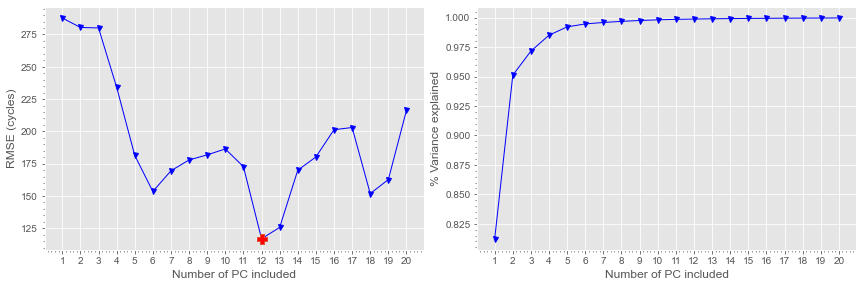

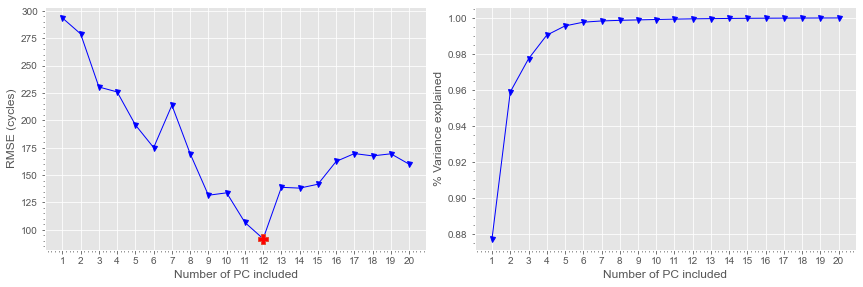

In [47]:
n_comp_pcr = optimise_pcr_cv(X_train_scaled, y_train)
n_comp_pcr_cycavg = optimise_pcr_cv(X_train_scaled_cycavg, y_train)

Odd cyclical trend in this plot.

#### Random forest

There are a lot of hyperparameters for the random forest algorithm, so we use a full-blown randomized search. The below code was adapted from [this page](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74). These seemed like reasonable ranges of hyperparameters but of course it's possible they will miss the optimum.

In [48]:
def optimize_random_forest_cv(X, y):
    
    # Define grid of hyperparameters
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]

    # Define random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    # Define model and grid
    rf = RandomForestRegressor()
    rf_random = RandomizedSearchCV(estimator = rf,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   cv = 5,
                                   verbose = 2,
                                   random_state = 0,
                                   n_jobs = -1)

    # Fit model
    rf_random.fit(X, y)
    
    print(rf_random.best_params_)

    return rf_random

Find RF models:

In [49]:
rf_random = optimize_random_forest_cv(X_train_scaled, y_train)
rf_random_cycavg = optimize_random_forest_cv(X_train_scaled_cycavg, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.0min finished


{'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.2min finished


{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


Define models to evaluate:

In [50]:
models = {
          'Ridge': RidgeCV(alphas=alphas, cv=5),
          'Elastic net': ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0, max_iter=100000),
          'PCR': make_pipeline(PCA(n_components=n_comp_pcr), LinearRegression()),
          'PLSR': PLSRegression(n_components=n_comp_plsr),
          'Random Forest': RandomForestRegressor(**rf_random.best_params_)
         }

models_cycavg = {
                 'Ridge': RidgeCV(alphas=alphas, cv=5),
                 'Elastic net': ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0, max_iter=100000),
                 'PCR': make_pipeline(PCA(n_components=n_comp_pcr_cycavg), LinearRegression()),
                 'PLSR': PLSRegression(n_components=n_comp_plsr_cycavg),
                 'Random Forest': RandomForestRegressor(**rf_random_cycavg.best_params_)
                 }

model_names = list(models.keys())

Evaluate error and plot:

Ridge RMSE: Train=85 cyc, Test1=125 cyc, Test2=188 cyc
Ridge RMSE, cycavg: Train=86 cyc, Test1=119 cyc, Test2=194 cyc

Elastic net RMSE: Train=92 cyc, Test1=132 cyc, Test2=196 cyc
Elastic net RMSE, cycavg: Train=94 cyc, Test1=126 cyc, Test2=195 cyc

PCR RMSE: Train=80 cyc, Test1=97 cyc, Test2=193 cyc
PCR RMSE, cycavg: Train=80 cyc, Test1=102 cyc, Test2=216 cyc

PLSR RMSE: Train=59 cyc, Test1=100 cyc, Test2=176 cyc
PLSR RMSE, cycavg: Train=65 cyc, Test1=103 cyc, Test2=182 cyc

Random Forest RMSE: Train=82 cyc, Test1=139 cyc, Test2=199 cyc
Random Forest RMSE, cycavg: Train=91 cyc, Test1=135 cyc, Test2=195 cyc



/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/peter/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


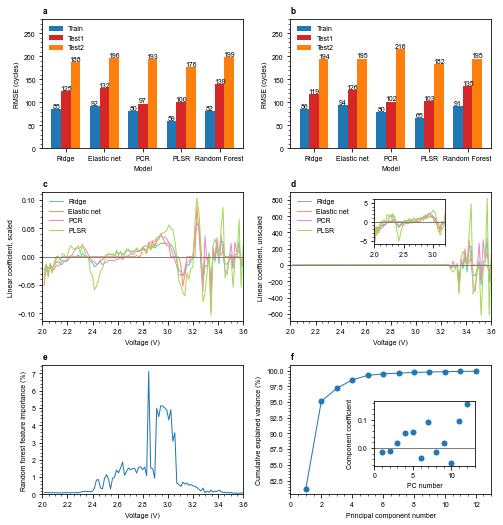

In [53]:
# Preinitialize
RMSE_train = np.zeros((len(models), ))
RMSE_test1 = np.zeros((len(models), ))
RMSE_test2 = np.zeros((len(models), ))

RMSE_train_cycavg = np.zeros((len(models), ))
RMSE_test1_cycavg = np.zeros((len(models), ))
RMSE_test2_cycavg = np.zeros((len(models), ))

# set width of bar
barWidth = 0.25

# model colors
model_colors = cm.get_cmap('Set2')([0, 1, 3, 4])

fig, ax = plt.subplots(figsize=(fig_width_2col, 3 * fig_height),
                       nrows = 3, ncols = 2)
ax = ax.ravel()

for k in np.arange(6):
    ax[k].set_title(chr(97+k), loc='left', weight='bold')

# Add insets
ax_inset3 = inset_axes(ax[3], width='100%', height='100%',
                       bbox_to_anchor=(0.4, 0.625, 0.35, 0.35),
                       bbox_transform=ax[3].transAxes,
                       loc='upper left')
ax_inset3.xaxis.set_minor_locator(AutoMinorLocator())
ax_inset3.set_xlim([2, 3.2])
ax_inset3.set_ylim([-6, 6])

ax_inset5 = inset_axes(ax[5], width='100%', height='100%',
                       bbox_to_anchor=(0.4, 0.25, 0.5, 0.5),
                       bbox_transform=ax[5].transAxes,
                       loc='upper left')
ax_inset5.xaxis.set_minor_locator(AutoMinorLocator())

for k, model_name in enumerate(models):
    
    # Get model objects
    model = models[model_name]
    model_cycavg = models_cycavg[model_name]
    
    # Fit models
    model.fit(X_train_scaled, y_train)
    model_cycavg.fit(X_train_scaled_cycavg, y_train)

    # Predict on train and test sets
    y_train_pred = model.predict(X_train_scaled)
    y_test1_pred = model.predict(X_test1_scaled)
    y_test2_pred = model.predict(X_test2_scaled)
    
    y_train_pred_cycavg = model.predict(X_train_scaled_cycavg)
    y_test1_pred_cycavg = model.predict(X_test1_scaled_cycavg)
    y_test2_pred_cycavg = model.predict(X_test2_scaled_cycavg)

    # Evaluate error
    RMSE_train[k] = mean_squared_error(np.power(10, y_train), np.power(10, y_train_pred), squared=False)
    RMSE_test1[k] = mean_squared_error(np.power(10, y_test1_mod), np.power(10, y_test1_pred), squared=False)
    RMSE_test2[k] = mean_squared_error(np.power(10, y_test2), np.power(10, y_test2_pred), squared=False)
    
    RMSE_train_cycavg[k] = mean_squared_error(np.power(10, y_train), np.power(10, y_train_pred_cycavg), squared=False)
    RMSE_test1_cycavg[k] = mean_squared_error(np.power(10, y_test1_mod), np.power(10, y_test1_pred_cycavg), squared=False)
    RMSE_test2_cycavg[k] = mean_squared_error(np.power(10, y_test2), np.power(10, y_test2_pred_cycavg), squared=False)
    
    # Display errors
    print(f'{model_name} RMSE: Train={RMSE_train[k]:.0f} cyc, Test1={RMSE_test1[k]:.0f} cyc, Test2={RMSE_test2[k]:.0f} cyc')
    print(f'{model_name} RMSE, cycavg: Train={RMSE_train_cycavg[k]:.0f} cyc, Test1={RMSE_test1_cycavg[k]:.0f} cyc, Test2={RMSE_test2_cycavg[k]:.0f} cyc\n')
    
    # Add coefficients results to other axes
    if hasattr(model, 'coef_'):
        
        coefs_log_cycles_per_mAh = model.coef_.reshape(-1) / scaler.scale_
        
        ax[2].plot(Vdlin[::freq], model.coef_, color=model_colors[k], label=model_name)
        ax[3].plot(Vdlin[::freq], coefs_log_cycles_per_mAh, color=model_colors[k], label=model_name)
        ax_inset3.plot(Vdlin[::freq], coefs_log_cycles_per_mAh, color=model_colors[k])
        
    if model_name == 'PCR': # Special case since coefs aren't an attribute in this pipeline
        
        pcr_lr_coefs = models['PCR'].named_steps['linearregression'].coef_
        pcr_comps = models['PCR'].named_steps['pca'].components_
        pcr_coefs = np.dot(pcr_lr_coefs, pcr_comps)
        coefs_log_cycles_per_mAh = pcr_coefs / scaler.scale_
        
        ax[2].plot(Vdlin[::freq], pcr_coefs, color=model_colors[k], label='PCR')
        ax[3].plot(Vdlin[::freq], coefs_log_cycles_per_mAh, color=model_colors[k], label='PCR')
        ax_inset3.plot(Vdlin[::freq], coefs_log_cycles_per_mAh, color=model_colors[k])
        
        # Plot components
        n_comps = np.arange(len(models['PCR'].named_steps['pca'].explained_variance_ratio_)) + 1
        explained_var_ratio = 100 * np.cumsum(models['PCR'].named_steps['pca'].explained_variance_ratio_)
        
        ax[5].plot(n_comps, explained_var_ratio, '-o')
        ax_inset5.plot(n_comps, pcr_lr_coefs, 'o')
            
    if hasattr(model, 'feature_importances_'): # RF
        ax[4].plot(Vdlin[::freq], 100 * model.feature_importances_)

# Plot error
x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars

ax[0].bar(x - width, RMSE_train, width, color='tab:blue', label='Train')
ax[0].bar(x, RMSE_test1, width, color='tab:red', label='Test1')
ax[0].bar(x + width, RMSE_test2, width, color='tab:orange', label='Test2')
ax[0].set_xticks(x)
ax[0].set_xticklabels(models)
ax[0].tick_params(axis='x', which='minor', bottom=False)
ax[0].set_ylim([0, 280])

ax[1].bar(x - width, RMSE_train_cycavg, width, color='tab:blue', label='Train')
ax[1].bar(x, RMSE_test1_cycavg, width, color='tab:red', label='Test1')
ax[1].bar(x + width, RMSE_test2_cycavg, width, color='tab:orange', label='Test2')
ax[1].set_xticks(x)
ax[1].set_xticklabels(models)
ax[1].tick_params(axis='x', which='minor', bottom=False)
ax[1].set_ylim([0, 280])

# Add labels to bar plots
text_offset = 2
for k in x:
    ax[0].text(k - width, RMSE_train[k] + text_offset,
               f'{RMSE_train[k]:.0f}', color='k', ha='center')
    ax[0].text(k, RMSE_test1[k] + text_offset,
               f'{RMSE_test1[k]:.0f}', color='k', ha='center')
    ax[0].text(k + width, RMSE_test2[k] + text_offset,
               f'{RMSE_test2[k]:.0f}', color='k', ha='center')
    
    ax[1].text(k - width, RMSE_train_cycavg[k] + text_offset,
               f'{RMSE_train_cycavg[k]:.0f}', color='k', ha='center')
    ax[1].text(k, RMSE_test1_cycavg[k] + text_offset,
               f'{RMSE_test1_cycavg[k]:.0f}', color='k', ha='center')
    ax[1].text(k + width, RMSE_test2_cycavg[k] + text_offset,
               f'{RMSE_test2_cycavg[k]:.0f}', color='k', ha='center')

    
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend()
ax[3].legend()

ax[0].set_xlabel('Model')
ax[1].set_xlabel('Model')
for k in [2, 3, 4]:
    ax[k].set_xlabel('Voltage (V)')
    ax[k].set_xlim([2.0, 3.6])
ax[5].set_xlabel('Principal component number')
ax_inset5.set_xlabel('PC number')

ax[2].axhline(0, color='tab:gray')
ax[3].axhline(0, color='tab:gray')
ax_inset3.axhline(0, color='tab:gray')
ax_inset5.axhline(0, color='tab:gray')

ax[4].set_ylim(bottom=0)
ax[5].set_xlim([0, 13])
ax_inset5.set_xlim([0, 13])

ax[0].set_ylabel('RMSE (cycles)')
ax[1].set_ylabel('RMSE (cycles)')
ax[2].set_ylabel('Linear coefficient, scaled')
ax[3].set_ylabel('Linear coefficient, unscaled')
ax[4].set_ylabel('Random forest feature importance (%)')
ax[5].set_ylabel('Cumulative explained variance (%)')
ax_inset5.set_ylabel('Component coefficient')

plt.tight_layout()
plt.savefig(figpath / 'fig7_multivariate.eps', format='eps')

## Whole voltage matrix

Here, we use the whole voltage matrix for prediction using a similar approach as above.

In [ ]:
# Define sampling frequency
freq = 10

# Define X matrices
X_train = DeltaQ_100_minus_10_train[:, ::freq]
X_test1 = DeltaQ_100_minus_10_test1[:, ::freq]
X_test2 = DeltaQ_100_minus_10_test2[:, ::freq]

# Scale via standarization
scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test1_scaled = scaler.transform(X_test1)
X_test2_scaled = scaler.transform(X_test2)

In [ ]:
n_comp_plsr = optimise_pls_cv(X_train_scaled, y_train)

In [ ]:
n_comp_pcr = optimise_pcr_cv(X_train_scaled, y_train)

In [ ]:
rf_random = optimize_random_forest_cv(X_train_scaled, y_train)

In [ ]:
models = {
          'Ridge': RidgeCV(alphas=alphas, cv=5),
          'Elastic net': ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0, max_iter=100000),
          'PCR': make_pipeline(PCA(n_components=n_comp_pcr), LinearRegression()),
          'PLSR': PLSRegression(n_components=n_comp_plsr),
          'Random Forest': RandomForestRegressor(**rf_random.best_params_)
         }

In [ ]:
# Preinitialize
RMSE_train = np.zeros((len(models), ))
RMSE_test1 = np.zeros((len(models), ))
RMSE_test2 = np.zeros((len(models), ))

for k, model_name in enumerate(models):
    
    # Get model object
    model = models[model_name]
    
    # Fit model
    model.fit(X_train_scaled, y_train)

    # Predict on train and test sets
    y_train_pred = model.predict(X_train_scaled)
    y_test1_pred = model.predict(X_test1_scaled)
    y_test2_pred = model.predict(X_test2_scaled)
    
    # Evaluate error
    RMSE_train[k] = mean_squared_error(np.power(10, y_train), np.power(10, y_train_pred), squared=False)
    RMSE_test1[k] = mean_squared_error(np.power(10, y_test1_mod), np.power(10, y_test1_pred), squared=False)
    RMSE_test2[k] = mean_squared_error(np.power(10, y_test2), np.power(10, y_test2_pred), squared=False)

    # Display errors
    print(f'{model_name} RMSE: Train={RMSE_train[k]:.0f} cyc, Test1={RMSE_test1[k]:.0f} cyc, Test2={RMSE_test2[k]:.0f} cyc')    